# Neural Network approaches based on Spectrograms

# Imports

In [1]:
import os
import time
import joblib
import librosa
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Activation, Input, TimeDistributed, MaxPooling2D, Conv2D, AveragePooling2D, LSTM, BatchNormalization, Reshape, MaxPool1D, MaxPooling1D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotnine as p9
import seaborn as sns

In [2]:
spectrogram_features = joblib.load('../dataset_processed/spectrogram_features.pkl')
mfcc_features = joblib.load('../dataset_processed/mfcc_features.pkl')
functional_features = joblib.load('../dataset_processed/functional_features.pkl')
aggregated_features = joblib.load('../dataset_processed/aggregated_features.pkl')

In [3]:
Y = functional_features['Emotion']
X = spectrogram_features

In [4]:
# print shapes of all X in a datafram
df = pd.DataFrame([x.shape for x in X])
df.head()

,0,1
0,128,99
1,128,101
2,128,94
3,128,81
4,128,88


In [5]:
# add zeroes for second dimension to make all X of same shape
dim2max = df[1].max()
X = [np.pad(x, ((0, 0), (0, dim2max - x.shape[1])), mode='constant', constant_values=0) for x in X]
df = pd.DataFrame([x.shape for x in X])
df.head()

,0,1
0,128,308
1,128,308
2,128,308
3,128,308
4,128,308


In [6]:
# crop each X to have siize 128x128
X = [x[:, :128] for x in X]
df = pd.DataFrame([x.shape for x in X])
df.head()

,0,1
0,128,128
1,128,128
2,128,128
3,128,128
4,128,128


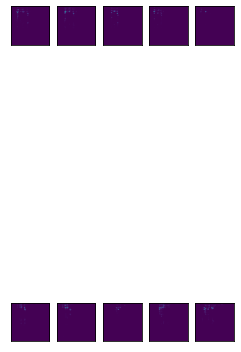

In [7]:
test_spectrograms = X[:10]
fig, axes = plt.subplots(2, 5, figsize=(4, 10), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(test_spectrograms[i])

In [8]:
Y_names = np.unique(Y)
Y_names

array(['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'],
      dtype=object)

In [9]:
Y = LabelEncoder().fit(Y).transform(Y)
Y

array([0, 1, 2, ..., 5, 5, 5])

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = to_categorical(Y_train, num_classes=np.unique(Y).size)
Y_test = to_categorical(Y_test, num_classes=np.unique(Y).size)

print(X_train[10].shape, X_test[10].shape)

(128, 128) (128, 128)


# Plot results

In [11]:
def plot_results(model, history, X_test, Y_test, Y_names):
    y_pred  = model.predict(X_test)
    y_pred  = np.argmax(y_pred, axis=1)
    y_check = np.argmax(Y_test,axis=1)
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')

    conf = confusion_matrix(y_check, y_pred)
    cm = pd.DataFrame(
        conf, index=[i for i in Y_names],
        columns=[i for i in Y_names]
    )

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 1 row and 2 columns

    # Plot on first axis
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')

    # Plot on second axis
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.loglog()
    ax2.legend(loc='lower right')

    ax3 = sns.heatmap(cm,annot=True,fmt='d')
    ax3.set_title(f'confusion matrix for model ')

    # Optional: Adjust spacing between plots (optional)
    plt.tight_layout()

    plt.show()

    print(f'Model Confusion Matrix\n', classification_report(y_check, y_pred, target_names=Y_names))

# CNN approach

## Simple CNN model

In [12]:
def Simple_CNN() :
    model = Sequential()
    model.add(Conv1D(64, 5, padding='same', input_shape=(128, 128)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(7))
    model.add(Activation('softmax'))
    print(model.summary())
    return model

### Parameters 1

In [19]:
Simple_CNN = Simple_CNN()
Simple_CNN.compile(optimizer=SGD(lr=0.01, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])
Simple_CNN_history = Simple_CNN.fit(X_train, Y_train, batch_size=64, epochs=100, validation_data=(X_test, Y_test))

Epoch 1/100


301/301 [==============================] - 8s 26ms/step - loss: 16.5957 - accuracy: 0.2090 - val_loss: 2.4310 - val_accuracy: 0.1978
Epoch 2/100
301/301 [==============================] - 7s 24ms/step - loss: 7.9089 - accuracy: 0.2092 - val_loss: 4.5151 - val_accuracy: 0.2063
Epoch 3/100
301/301 [==============================] - 7s 23ms/step - loss: 60.3970 - accuracy: 0.2088 - val_loss: 3.7405 - val_accuracy: 0.2063
Epoch 4/100
301/301 [==============================] - 7s 22ms/step - loss: 114.1670 - accuracy: 0.2120 - val_loss: 5.4775 - val_accuracy: 0.2061
Epoch 5/100
301/301 [==============================] - 7s 24ms/step - loss: 40.0540 - accuracy: 0.2129 - val_loss: 2.1786 - val_accuracy: 0.2069
Epoch 6/100
301/301 [==============================] - 7s 22ms/step - loss: 27.8312 - accuracy: 0.2142 - val_loss: 2.0621 - val_accuracy: 0.1939
Epoch 7/100
301/301 [==============================] - 6s 21ms/step - loss: 1.8591 - accuracy: 0.1984 - val_loss: 2.0706 - val_accuracy: 0.192

#### Results

  1/258 [..............................] - ETA: 14s

258/258 [==============================] - 9s 35ms/step
Test Loss: 1.9181711673736572
Test Accuracy: 0.4168894290924072


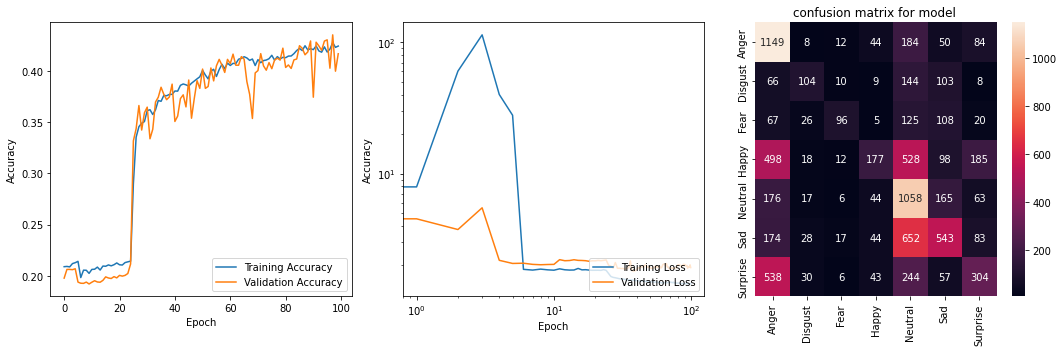

Model Confusion Matrix
               precision    recall  f1-score   support

       Anger       0.43      0.75      0.55      1531
     Disgust       0.45      0.23      0.31       444
        Fear       0.60      0.21      0.32       447
       Happy       0.48      0.12      0.19      1516
     Neutral       0.36      0.69      0.47      1529
         Sad       0.48      0.35      0.41      1541
    Surprise       0.41      0.25      0.31      1222

    accuracy                           0.42      8230
   macro avg       0.46      0.37      0.36      8230
weighted avg       0.44      0.42      0.38      8230



In [98]:
plot_results(Simple_CNN, Simple_CNN_history, X_test, Y_test, Y_names)

### Parameters 2

In [86]:
Simple_CNN_2 = Simple_CNN()
Simple_CNN_2.compile(optimizer=SGD(lr=0.001, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])
Simple_CNN_history_2 = Simple_CNN_2.fit(X_train, Y_train, batch_size=64, epochs=100, validation_data=(X_test, Y_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 128, 64)           41024     
                                                                 
 activation_4 (Activation)   (None, 128, 64)           0         
                                                                 
 dropout_1 (Dropout)         (None, 128, 64)           0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 7)                 57351     
                                                                 
 activation_5 (Activation)   (None, 7)                 0         
                                                                 
Total params: 98,375
Trainable params: 98,375
Non-trai

c:\Users\Hubert\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.


301/301 [==============================] - 5s 17ms/step - loss: 6.5190 - accuracy: 0.2270 - val_loss: 2.4637 - val_accuracy: 0.2593
Epoch 2/100
301/301 [==============================] - 5s 17ms/step - loss: 2.2190 - accuracy: 0.2859 - val_loss: 2.1736 - val_accuracy: 0.2694
Epoch 3/100
301/301 [==============================] - 5s 16ms/step - loss: 1.8835 - accuracy: 0.3083 - val_loss: 2.0429 - val_accuracy: 0.2914
Epoch 4/100
301/301 [==============================] - 5s 16ms/step - loss: 1.7323 - accuracy: 0.3263 - val_loss: 1.9713 - val_accuracy: 0.3145
Epoch 5/100
301/301 [==============================] - 5s 16ms/step - loss: 1.6349 - accuracy: 0.3581 - val_loss: 1.9065 - val_accuracy: 0.3341
Epoch 6/100
301/301 [==============================] - 5s 16ms/step - loss: 1.5755 - accuracy: 0.3763 - val_loss: 1.8769 - val_accuracy: 0.3385
Epoch 7/100
301/301 [==============================] - 5s 16ms/step - loss: 1.5412 - accuracy: 0.3897 - val_loss: 1.8661 - val_accuracy: 0.3554
Epoc

#### Results

  1/258 [..............................] - ETA: 13s

258/258 [==============================] - 9s 34ms/step
Test Loss: 2.3466732501983643
Test Accuracy: 0.5021871328353882


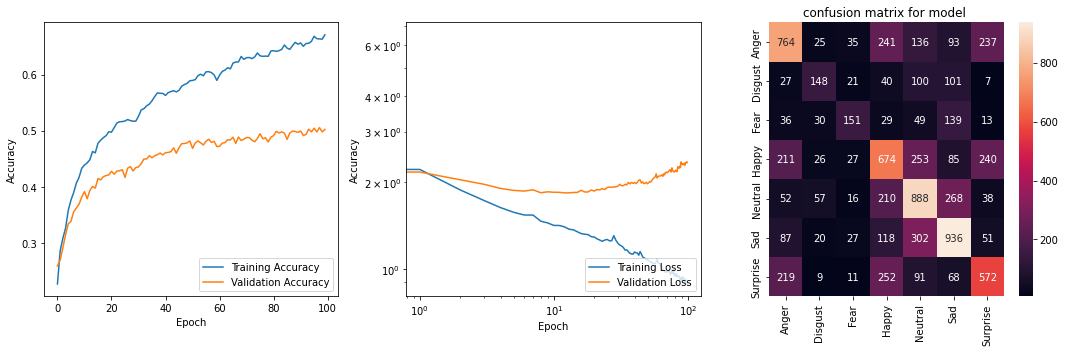

Model Confusion Matrix
               precision    recall  f1-score   support

       Anger       0.55      0.50      0.52      1531
     Disgust       0.47      0.33      0.39       444
        Fear       0.52      0.34      0.41       447
       Happy       0.43      0.44      0.44      1516
     Neutral       0.49      0.58      0.53      1529
         Sad       0.55      0.61      0.58      1541
    Surprise       0.49      0.47      0.48      1222

    accuracy                           0.50      8230
   macro avg       0.50      0.47      0.48      8230
weighted avg       0.50      0.50      0.50      8230



In [99]:
plot_results(Simple_CNN_2, Simple_CNN_history_2, X_test, Y_test, Y_names)

### Parameters 3

In [13]:
Simple_CNN_3 = Simple_CNN()
Simple_CNN_3.compile(optimizer=SGD(lr=0.001, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])
Simple_CNN_history_3 = Simple_CNN_3.fit(X_train, Y_train, batch_size=64, epochs=100, validation_data=(X_test, Y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 128, 64)           41024     
                                                                 
 activation (Activation)     (None, 128, 64)           0         
                                                                 
 dropout (Dropout)           (None, 128, 64)           0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 7)                 57351     
                                                                 
 activation_1 (Activation)   (None, 7)                 0         
                                                                 
Total params: 98,375
Trainable params: 98,375
Non-traina

c:\Users\Hubert\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.


301/301 [==============================] - 6s 19ms/step - loss: 6.5962 - accuracy: 0.2220 - val_loss: 2.4795 - val_accuracy: 0.2604
Epoch 2/100
301/301 [==============================] - 5s 17ms/step - loss: 2.1907 - accuracy: 0.2865 - val_loss: 2.2535 - val_accuracy: 0.2866
Epoch 3/100
301/301 [==============================] - 5s 16ms/step - loss: 1.8962 - accuracy: 0.3014 - val_loss: 2.0632 - val_accuracy: 0.2875
Epoch 4/100
301/301 [==============================] - 6s 19ms/step - loss: 1.7538 - accuracy: 0.3290 - val_loss: 2.0017 - val_accuracy: 0.3050
Epoch 5/100
301/301 [==============================] - 6s 20ms/step - loss: 1.6504 - accuracy: 0.3627 - val_loss: 1.9580 - val_accuracy: 0.3346
Epoch 6/100
301/301 [==============================] - 6s 19ms/step - loss: 1.5934 - accuracy: 0.3855 - val_loss: 1.8987 - val_accuracy: 0.3498
Epoch 7/100
301/301 [==============================] - 5s 17ms/step - loss: 1.5298 - accuracy: 0.4080 - val_loss: 1.8328 - val_accuracy: 0.3679
Epoc

#### Results

 17/258 [>.............................] - ETA: 0s 

258/258 [==============================] - 1s 3ms/step
Test Loss: 2.348202705383301
Test Accuracy: 0.4844471514225006


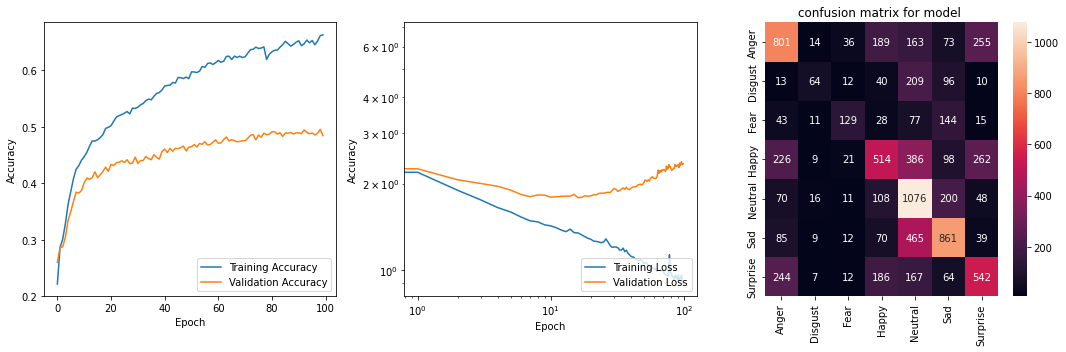

Model Confusion Matrix
               precision    recall  f1-score   support

       Anger       0.54      0.52      0.53      1531
     Disgust       0.49      0.14      0.22       444
        Fear       0.55      0.29      0.38       447
       Happy       0.45      0.34      0.39      1516
     Neutral       0.42      0.70      0.53      1529
         Sad       0.56      0.56      0.56      1541
    Surprise       0.46      0.44      0.45      1222

    accuracy                           0.48      8230
   macro avg       0.50      0.43      0.44      8230
weighted avg       0.49      0.48      0.47      8230



In [14]:
plot_results(Simple_CNN_3, Simple_CNN_history_3, X_test, Y_test, Y_names)

## Simple CNN model small

In [40]:
def Simple_CNN_small() :
    model = Sequential()
    model.add(Conv1D(32, 5, padding='same', input_shape=(128, 128)))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(7))
    model.add(Activation('softmax'))
    print(model.summary())
    return model

### Parameters 1 

In [42]:
Simple_CNN_small_1 = Simple_CNN_small()
Simple_CNN_small_1.compile(optimizer=SGD(lr=0.005, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])
Simple_CNN_small_history_1 = Simple_CNN_small_1.fit(X_train, Y_train, batch_size=64, epochs=300, validation_data=(X_test, Y_test))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 128, 32)           20512     
                                                                 
 activation_20 (Activation)  (None, 128, 32)           0         
                                                                 
 dropout_10 (Dropout)        (None, 128, 32)           0         
                                                                 
 flatten_9 (Flatten)         (None, 4096)              0         
                                                                 
 dense_9 (Dense)             (None, 7)                 28679     
                                                                 
 activation_21 (Activation)  (None, 7)                 0         
                                                                 
Total params: 49,191
Trainable params: 49,191
Non-trai

301/301 [==============================] - 4s 12ms/step - loss: 5.6968 - accuracy: 0.2080 - val_loss: 1.9454 - val_accuracy: 0.1959
Epoch 2/300
301/301 [==============================] - 3s 11ms/step - loss: 1.9103 - accuracy: 0.2048 - val_loss: 1.8807 - val_accuracy: 0.1988
Epoch 3/300
301/301 [==============================] - 3s 11ms/step - loss: 2.0584 - accuracy: 0.2060 - val_loss: 1.8795 - val_accuracy: 0.2030
Epoch 4/300
301/301 [==============================] - 3s 11ms/step - loss: 1.8901 - accuracy: 0.2115 - val_loss: 1.9211 - val_accuracy: 0.2047
Epoch 5/300
301/301 [==============================] - 3s 12ms/step - loss: 1.8222 - accuracy: 0.2351 - val_loss: 1.7880 - val_accuracy: 0.3148
Epoch 6/300
301/301 [==============================] - 3s 11ms/step - loss: 1.6785 - accuracy: 0.3277 - val_loss: 1.6525 - val_accuracy: 0.3617
Epoch 7/300
301/301 [==============================] - 3s 11ms/step - loss: 1.6446 - accuracy: 0.3378 - val_loss: 1.6290 - val_accuracy: 0.3531
Epoc

#### Results

 80/258 [========>.....................] - ETA: 0s

258/258 [==============================] - 1s 2ms/step
Test Loss: 1.878043532371521
Test Accuracy: 0.45637911558151245


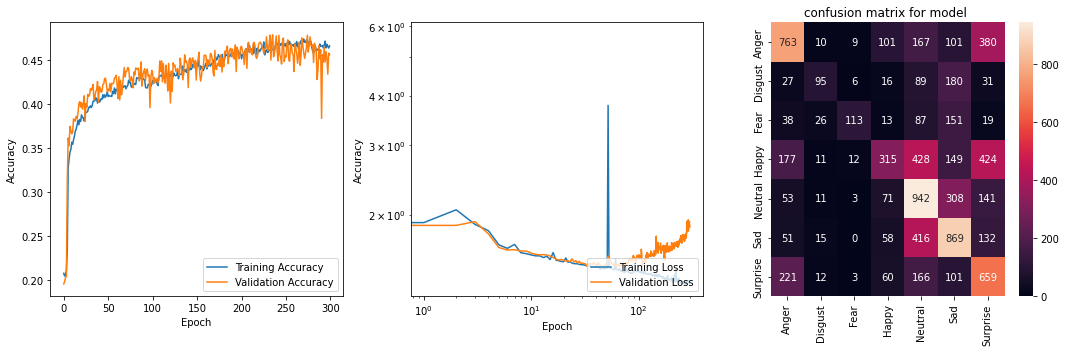

Model Confusion Matrix
               precision    recall  f1-score   support

       Anger       0.57      0.50      0.53      1531
     Disgust       0.53      0.21      0.30       444
        Fear       0.77      0.25      0.38       447
       Happy       0.50      0.21      0.29      1516
     Neutral       0.41      0.62      0.49      1529
         Sad       0.47      0.56      0.51      1541
    Surprise       0.37      0.54      0.44      1222

    accuracy                           0.46      8230
   macro avg       0.52      0.41      0.42      8230
weighted avg       0.49      0.46      0.44      8230



In [43]:
plot_results(Simple_CNN_small_1, Simple_CNN_small_history_1, X_test, Y_test, Y_names)

## Double CNN

In [19]:
def Double_CNN() :
    model = Sequential()
    model.add(Conv1D(64, 5, padding='same', input_shape=(128, 128)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Conv1D(64, 5, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(7))
    model.add(Activation('softmax'))
    print(model.summary())
    return model

### Parameters 1

In [20]:
Double_CNN_1 = Double_CNN()
Double_CNN_1.compile(optimizer=SGD(lr=0.001, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])
Double_CNN_history_1 = Double_CNN_1.fit(X_train, Y_train, batch_size=64, epochs=100, validation_data=(X_test, Y_test))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 128, 64)           41024     
                                                                 
 batch_normalization_3 (Batc  (None, 128, 64)          256       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 128, 64)           0         
                                                                 
 dropout_3 (Dropout)         (None, 128, 64)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 128, 64)           20544     
                                                                 
 batch_normalization_4 (Batc  (None, 128, 64)          256       
 hNormalization)                                      

301/301 [==============================] - 12s 37ms/step - loss: 1.9175 - accuracy: 0.2940 - val_loss: 1.7850 - val_accuracy: 0.2786
Epoch 2/100
301/301 [==============================] - 11s 37ms/step - loss: 1.7750 - accuracy: 0.3316 - val_loss: 1.7418 - val_accuracy: 0.2948
Epoch 3/100
301/301 [==============================] - 11s 36ms/step - loss: 1.7153 - accuracy: 0.3474 - val_loss: 1.7276 - val_accuracy: 0.3030
Epoch 4/100
301/301 [==============================] - 12s 39ms/step - loss: 1.6740 - accuracy: 0.3594 - val_loss: 1.6894 - val_accuracy: 0.3426
Epoch 5/100
301/301 [==============================] - 11s 36ms/step - loss: 1.6395 - accuracy: 0.3752 - val_loss: 1.6969 - val_accuracy: 0.2961
Epoch 6/100
301/301 [==============================] - 11s 36ms/step - loss: 1.6165 - accuracy: 0.3823 - val_loss: 1.6686 - val_accuracy: 0.3033
Epoch 7/100
301/301 [==============================] - 11s 37ms/step - loss: 1.5903 - accuracy: 0.3862 - val_loss: 1.6603 - val_accuracy: 0.30

##### Results

258/258 [==============================] - 1s 4ms/step
Test Loss: 2.818981409072876
Test Accuracy: 0.22782503068447113


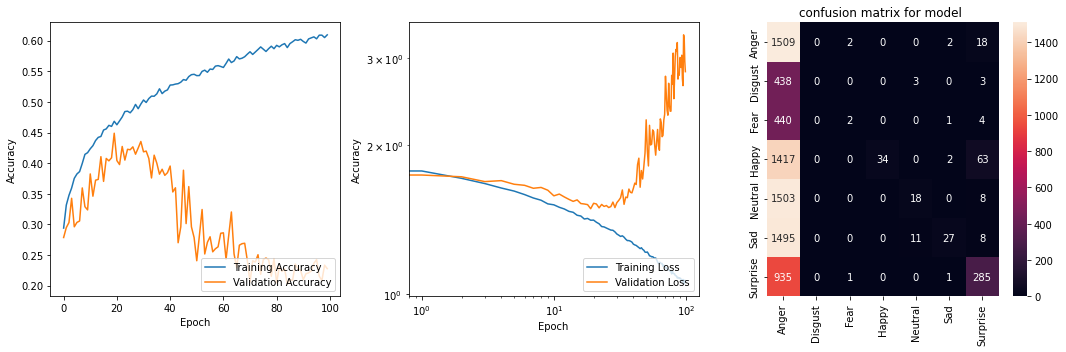

Model Confusion Matrix
               precision    recall  f1-score   support

       Anger       0.20      0.99      0.33      1531
     Disgust       0.00      0.00      0.00       444
        Fear       0.40      0.00      0.01       447
       Happy       1.00      0.02      0.04      1516
     Neutral       0.56      0.01      0.02      1529
         Sad       0.82      0.02      0.03      1541
    Surprise       0.73      0.23      0.35      1222

    accuracy                           0.23      8230
   macro avg       0.53      0.18      0.11      8230
weighted avg       0.61      0.23      0.13      8230



c:\Users\Hubert\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\Hubert\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\Hubert\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [21]:
plot_results(Double_CNN_1, Double_CNN_history_1, X_test, Y_test, Y_names)

## Normalized CNN

In [22]:
def Normalized_CNN() :
    model = Sequential()
    model.add(Conv1D(64, 5, padding='same', input_shape=(128, 128)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(7))
    model.add(Activation('softmax'))
    print(model.summary())
    return model

### Parameters 1

In [23]:
Normalized_CNN_1 = Normalized_CNN()
Normalized_CNN_1.compile(optimizer=SGD(lr=0.003, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])
Normalized_CNN_history_1 = Normalized_CNN_1.fit(X_train, Y_train, batch_size=64, epochs=100, validation_data=(X_test, Y_test))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 128, 64)           41024     
                                                                 
 batch_normalization_5 (Batc  (None, 128, 64)          256       
 hNormalization)                                                 
                                                                 
 activation_10 (Activation)  (None, 128, 64)           0         
                                                                 
 dropout_5 (Dropout)         (None, 128, 64)           0         
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 7)                 57351     
                                                      

c:\Users\Hubert\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.


301/301 [==============================] - 7s 22ms/step - loss: 1.9733 - accuracy: 0.3139 - val_loss: 1.7572 - val_accuracy: 0.3559
Epoch 2/100
301/301 [==============================] - 6s 20ms/step - loss: 1.6871 - accuracy: 0.3717 - val_loss: 1.6910 - val_accuracy: 0.3729
Epoch 3/100
301/301 [==============================] - 6s 20ms/step - loss: 1.5751 - accuracy: 0.4070 - val_loss: 1.6573 - val_accuracy: 0.3974
Epoch 4/100
301/301 [==============================] - 6s 20ms/step - loss: 1.5140 - accuracy: 0.4369 - val_loss: 1.6049 - val_accuracy: 0.4313
Epoch 5/100
301/301 [==============================] - 6s 20ms/step - loss: 1.4615 - accuracy: 0.4542 - val_loss: 1.5899 - val_accuracy: 0.4363
Epoch 6/100
301/301 [==============================] - 6s 20ms/step - loss: 1.4189 - accuracy: 0.4723 - val_loss: 1.5733 - val_accuracy: 0.4334
Epoch 7/100
301/301 [==============================] - 6s 20ms/step - loss: 1.3940 - accuracy: 0.4778 - val_loss: 1.5396 - val_accuracy: 0.4499
Epoc

#### Results

 15/258 [>.............................] - ETA: 0s

258/258 [==============================] - 1s 3ms/step
Test Loss: 1.505897045135498
Test Accuracy: 0.5409477353096008


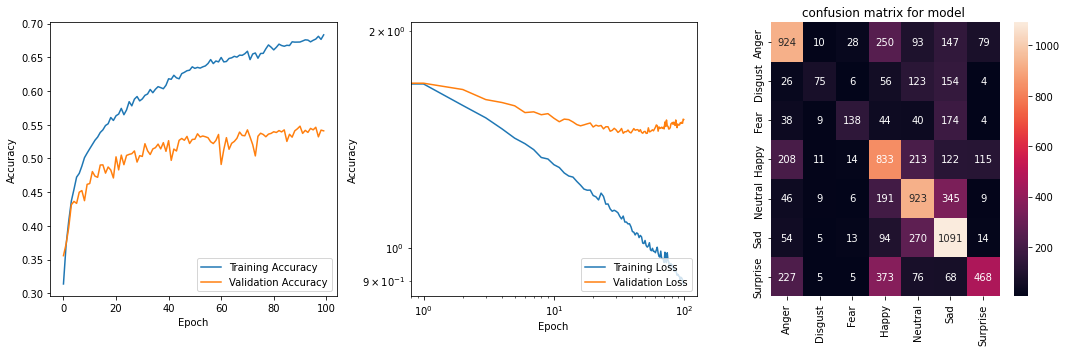

Model Confusion Matrix
               precision    recall  f1-score   support

       Anger       0.61      0.60      0.61      1531
     Disgust       0.60      0.17      0.26       444
        Fear       0.66      0.31      0.42       447
       Happy       0.45      0.55      0.50      1516
     Neutral       0.53      0.60      0.57      1529
         Sad       0.52      0.71      0.60      1541
    Surprise       0.68      0.38      0.49      1222

    accuracy                           0.54      8230
   macro avg       0.58      0.48      0.49      8230
weighted avg       0.56      0.54      0.53      8230



In [25]:
plot_results(Normalized_CNN_1, Normalized_CNN_history_1, X_test, Y_test, Y_names)

# CNN + LSTM approach

## Complex Model

In [31]:
def CNN_LSTM():
    model = Sequential(name='model2d')
    #LFLB1
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     input_shape=(128, 128, 1)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=2, strides=2))

    #LFLB2
    model.add(Conv2D(filters=64,
                    kernel_size=3,
                    strides=1,
                    padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=4, strides=4))
    #LFLB3
    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     strides=1,
                     padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=4, strides=4))

    #LFLB4
    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     strides=1,
                     padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=4, strides=4))

    model.add(Reshape((-1, 128)))
    #LSTM
    model.add(LSTM(32))
    model.add(Dense(units=7, activation='softmax'))
    
    print(model.summary())
    return model

In [32]:
model_CNN_LSTM = CNN_LSTM()
model_CNN_LSTM.compile(optimizer=SGD(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
history_CNN_LSTM = model_CNN_LSTM.fit(X_train, Y_train, batch_size=64, epochs=20, validation_data=(X_test, Y_test))

Model: "model2d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      640       
                                                                 
 batch_normalization_4 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_14 (Activation)  (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_5 (Batc  (None, 64, 64, 64)       256 

258/258 - 26s - loss: 1.6120 - accuracy: 0.4087 - 26s/epoch - 100ms/step


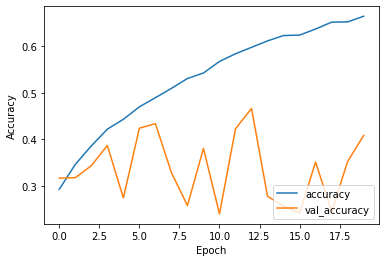

In [33]:
plt.plot(history_CNN_LSTM.history['accuracy'], label='accuracy')
plt.plot(history_CNN_LSTM.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = model_CNN_LSTM.evaluate(X_test,  Y_test, verbose=2)

## Simple approach with MaxPooling

In [100]:
def CNN_LSTM_simple():
    model = Sequential()
    model.add(Conv1D(64, 5, padding='same', input_shape=(128, 128)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(pool_size=4, strides=4))
    model.add(LSTM(32))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    print(model.summary())
    return model

### Parameters 1

In [101]:
model_CNN_LSTM_simple = CNN_LSTM_simple()
model_CNN_LSTM_simple.compile(optimizer=SGD(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
history_CNN_LSTM_simple = model_CNN_LSTM_simple.fit(X_train, Y_train, batch_size=64, epochs=20, validation_data=(X_test, Y_test))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 128, 64)           41024     
                                                                 
 activation_6 (Activation)   (None, 128, 64)           0         
                                                                 
 dropout_2 (Dropout)         (None, 128, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 32, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 7)                 231       
                                                      

c:\Users\Hubert\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.


301/301 [==============================] - 65s 213ms/step - loss: 1.8883 - accuracy: 0.2633 - val_loss: 1.8467 - val_accuracy: 0.3062
Epoch 2/20
301/301 [==============================] - 63s 209ms/step - loss: 1.8126 - accuracy: 0.3137 - val_loss: 1.7743 - val_accuracy: 0.3210
Epoch 3/20
301/301 [==============================] - 62s 205ms/step - loss: 1.7317 - accuracy: 0.3177 - val_loss: 1.7007 - val_accuracy: 0.3254
Epoch 4/20
301/301 [==============================] - 62s 207ms/step - loss: 1.6740 - accuracy: 0.3190 - val_loss: 1.6632 - val_accuracy: 0.3230
Epoch 5/20
301/301 [==============================] - 61s 201ms/step - loss: 1.6493 - accuracy: 0.3315 - val_loss: 1.6527 - val_accuracy: 0.3371
Epoch 6/20
301/301 [==============================] - 60s 198ms/step - loss: 1.6387 - accuracy: 0.3366 - val_loss: 1.6417 - val_accuracy: 0.3320
Epoch 7/20
301/301 [==============================] - 59s 197ms/step - loss: 1.6324 - accuracy: 0.3328 - val_loss: 1.6418 - val_accuracy: 0.3

#### Results

258/258 [==============================] - 8s 31ms/step
Test Loss: 1.9151901006698608
Test Accuracy: 0.2957472801208496


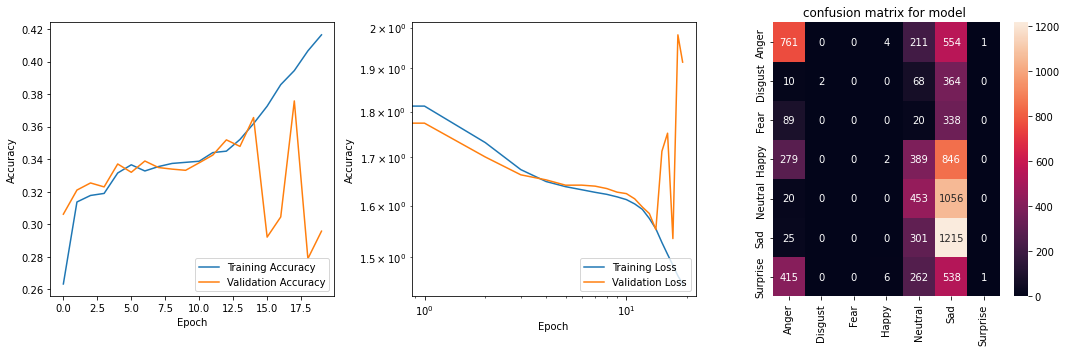

Model Confusion Matrix
               precision    recall  f1-score   support

       Anger       0.48      0.50      0.49      1531
     Disgust       1.00      0.00      0.01       444
        Fear       0.00      0.00      0.00       447
       Happy       0.17      0.00      0.00      1516
     Neutral       0.27      0.30      0.28      1529
         Sad       0.25      0.79      0.38      1541
    Surprise       0.50      0.00      0.00      1222

    accuracy                           0.30      8230
   macro avg       0.38      0.23      0.17      8230
weighted avg       0.34      0.30      0.21      8230



c:\Users\Hubert\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\Hubert\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\Hubert\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [102]:
plot_results(model_CNN_LSTM_simple, history_CNN_LSTM_simple, X_test, Y_test, Y_names)

## Simple approach no MaxPooling

In [105]:
def CNN_LSTM_simple_nopool():
    model = Sequential()
    model.add(Conv1D(64, 5, padding='same', input_shape=(128, 128)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(LSTM(16))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    print(model.summary())
    return model

### Parameters 1

In [106]:
simple_CNN_LSTM_no_pool = CNN_LSTM_simple_nopool()
simple_CNN_LSTM_no_pool.compile(optimizer=SGD(lr=0.05, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])
history_simple_CNN_LSTM_no_pool = simple_CNN_LSTM_no_pool.fit(X_train, Y_train, batch_size=64, epochs=20, validation_data=(X_test, Y_test))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 128, 64)           41024     
                                                                 
 activation_10 (Activation)  (None, 128, 64)           0         
                                                                 
 dropout_4 (Dropout)         (None, 128, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 16)                5184      
                                                                 
 dense_5 (Dense)             (None, 7)                 119       
                                                                 
 activation_11 (Activation)  (None, 7)                 0         
                                                                 
Total params: 46,327
Trainable params: 46,327
Non-trai

c:\Users\Hubert\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.


301/301 [==============================] - 66s 215ms/step - loss: 1.8561 - accuracy: 0.1890 - val_loss: 1.8514 - val_accuracy: 0.1874
Epoch 2/20
301/301 [==============================] - 62s 208ms/step - loss: 1.8305 - accuracy: 0.2200 - val_loss: 1.6821 - val_accuracy: 0.3237
Epoch 3/20
301/301 [==============================] - 62s 206ms/step - loss: 1.6416 - accuracy: 0.3239 - val_loss: 1.8230 - val_accuracy: 0.2668
Epoch 4/20
301/301 [==============================] - 62s 207ms/step - loss: 1.6426 - accuracy: 0.3190 - val_loss: 1.6405 - val_accuracy: 0.3211
Epoch 5/20
301/301 [==============================] - 64s 211ms/step - loss: 1.6217 - accuracy: 0.3320 - val_loss: 1.6337 - val_accuracy: 0.3286
Epoch 6/20
301/301 [==============================] - 62s 206ms/step - loss: 1.6097 - accuracy: 0.3358 - val_loss: 1.6172 - val_accuracy: 0.3416
Epoch 7/20
301/301 [==============================] - 61s 204ms/step - loss: 1.5966 - accuracy: 0.3398 - val_loss: 1.6538 - val_accuracy: 0.3

#### Results

258/258 [==============================] - 10s 39ms/step
Test Loss: 1.5419082641601562
Test Accuracy: 0.3633049726486206


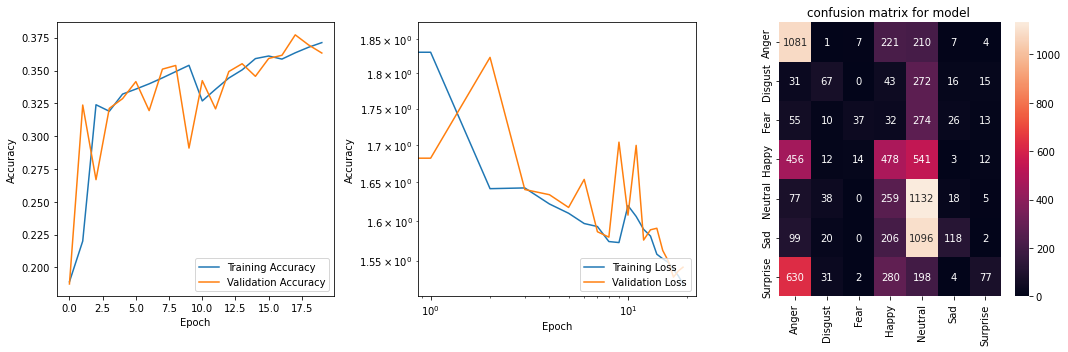

Model Confusion Matrix
               precision    recall  f1-score   support

       Anger       0.45      0.71      0.55      1531
     Disgust       0.37      0.15      0.22       444
        Fear       0.62      0.08      0.15       447
       Happy       0.31      0.32      0.31      1516
     Neutral       0.30      0.74      0.43      1529
         Sad       0.61      0.08      0.14      1541
    Surprise       0.60      0.06      0.11      1222

    accuracy                           0.36      8230
   macro avg       0.47      0.30      0.27      8230
weighted avg       0.46      0.36      0.30      8230



In [107]:
plot_results(simple_CNN_LSTM_no_pool, history_simple_CNN_LSTM_no_pool, X_test, Y_test, Y_names)

## Semi-complex approach

In [ ]:
def CNN_LSTM_semi():
    model=tf.keras.Sequential([
        Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
        BatchNormalization(),
        MaxPool1D(pool_size=5,strides=2,padding='same'),
        Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
        BatchNormalization(),
        MaxPool1D(pool_size=5,strides=2,padding='same'),
        Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
        BatchNormalization(),
        MaxPool1D(pool_size=5,strides=2,padding='same'),
        Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
        BatchNormalization(),
        MaxPool1D(pool_size=5,strides=2,padding='same'),
        Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
        BatchNormalization(),
        MaxPool1D(pool_size=3,strides=2,padding='same'),
        Flatten(),
        Dense(512,activation='relu'),
        BatchNormalization(),
        Dense(7,activation='softmax')
    ])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()